<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#载入原始" data-toc-modified-id="载入原始-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>载入原始</a></span></li><li><span><a href="#切割2+26城市" data-toc-modified-id="切割2+26城市-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>切割2+26城市</a></span></li><li><span><a href="#尺寸转换" data-toc-modified-id="尺寸转换-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>尺寸转换</a></span><ul class="toc-item"><li><span><a href="#12-km-KD-tree方法" data-toc-modified-id="12-km-KD-tree方法-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>12 km KD-tree方法</a></span></li></ul></li><li><span><a href="#存储" data-toc-modified-id="存储-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>存储</a></span></li><li><span><a href="#skimage重采样新方法" data-toc-modified-id="skimage重采样新方法-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>skimage重采样新方法</a></span></li></ul></div>

In [15]:
# 库
# library
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np

from pointprocess import *
# from lightning_setup import *
# from titan import *
import cartopy
from cartopy.io.img_tiles import StamenTerrain
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import BORDERS
from cartopy.io.img_tiles import StamenTerrain
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline
import io
import requests
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as col
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader
%matplotlib inline

# 载入原始

In [18]:
from osgeo import gdal
pathToRaster = r"./../data/GDPGrid_China2010/cngdp2010.tif"
input_raster = gdal.Open(pathToRaster)
prj=input_raster.GetProjection()
srs=osr.SpatialReference(wkt=prj)
if srs.IsProjected:
    print srs.GetAttrValue('projcs')
print srs.GetAttrValue('geogcs')
#output_raster = r'././../data/GDPGrid_China2010/cngdp2010_adjust.tif'
#gdal.Warp(output_raster,input_raster,dstSRS='EPSG:4326',dstNodata = -9999)

Albers_Conic_Equal_Area
GCS_Unknown_datum_based_upon_the_Krassowsky_1940_ellipsoid


In [17]:
from osgeo import gdal,ogr,osr
def GetExtent(gt,cols,rows):
    ''' Return list of corner coordinates from a geotransform

        @type gt:   C{tuple/list}
        @param gt: geotransform
        @type cols:   C{int}
        @param cols: number of columns in the dataset
        @type rows:   C{int}
        @param rows: number of rows in the dataset
        @rtype:    C{[float,...,float]}
        @return:   coordinates of each corner
    '''
    ext=[]
    xarr=[0,cols]
    yarr=[0,rows]

    for px in xarr:
        for py in yarr:
            x=gt[0]+(px*gt[1])+(py*gt[2])
            y=gt[3]+(px*gt[4])+(py*gt[5])
            ext.append([x,y])
            print x,y
        yarr.reverse()
    return ext
def ReprojectCoords(coords,src_srs,tgt_srs):
    ''' Reproject a list of x,y coordinates.

        @type geom:     C{tuple/list}
        @param geom:    List of [[x,y],...[x,y]] coordinates
        @type src_srs:  C{osr.SpatialReference}
        @param src_srs: OSR SpatialReference object
        @type tgt_srs:  C{osr.SpatialReference}
        @param tgt_srs: OSR SpatialReference object
        @rtype:         C{tuple/list}
        @return:        List of transformed [[x,y],...[x,y]] coordinates
    '''
    trans_coords=[]
    transform = osr.CoordinateTransformation( src_srs, tgt_srs)
    for x,y in coords:
        x,y,z = transform.TransformPoint(x,y)
        trans_coords.append([x,y])
    return trans_coords

In [190]:
input_raster = r"./../data/GDPGrid_China2010/cngdp2010_adjust.tif" #This file I want to clip
ds=gdal.Open(input_raster)
prj=ds.GetProjection()
print prj
srs=osr.SpatialReference(wkt=prj)
if srs.IsProjected:
    print srs.GetAttrValue('projcs')
print srs.GetAttrValue('geogcs')

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
None
WGS 84


# 切割2+26城市

In [8]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
input_shape = r'./2+26/2+26城市整体.shp'
shapefile = gpd.read_file(input_shape)
shapefile = shapefile.to_crs(epsg=4326)
input_raster = r"./../data/GDPGrid_China2010/GDP-2.tif" #This file I want to clip
geoms = shapefile.geometry.values # list of shapely geometries
output_raster = r'./../data/GDPGrid_China2010/2+26_gdp.tif'
geometry = geoms[0] # shapely geometry
from shapely.geometry import mapping
geoms = [mapping(geoms[0])]
with rasterio.open(input_raster) as src:
    out_image, out_transform = mask(src, geoms, crop=True) ## 出现了不配套的情况，怎么办
    out_meta = src.meta.copy()        
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(output_raster, "w", **out_meta) as dest:
    dest.write(out_image)  

# 尺寸转换

In [215]:
import cartopy.crs as ccrs
import rasterio
pathToRaster = r'././../data/GDPGrid_China2010/2+26_gdp.tif'
raster = gdal.Open(pathToRaster,  gdal.GA_ReadOnly)
array  = raster.GetRasterBand(1).ReadAsArray()
array  = array[::-1]
array[array == -9999] = np.nan
width  = raster.RasterXSize
height = raster.RasterYSize
gt     = raster.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 
cols = raster.RasterXSize
rows = raster.RasterYSize
ext=GetExtent(gt,cols,rows)
src_srs=osr.SpatialReference()
src_srs.ImportFromWkt(raster.GetProjection())
#tgt_srs=osr.SpatialReference()
#tgt_srs.ImportFromEPSG(4326)
tgt_srs = src_srs.CloneGeogCS()
geo_ext=ReprojectCoords(ext,src_srs,tgt_srs)
## 学习网格转换
lon = np.linspace(minx,maxx,width)
lat = np.linspace(miny,maxy,height)

111.510504804 41.0636432942
111.510504804 34.1940028372
119.321870865 34.1940028372
119.321870865 41.0636432942


In [216]:
## 学习网格转换
lon = np.linspace(minx,maxx,width)
lat = np.linspace(miny,maxy,height)

In [217]:
xx,yy  = np.meshgrid(lon,lat)
print xx.shape
print array.shape

(693, 788)
(693, 788)


In [4]:
crs = ccrs.PlateCarree()
x0,x1,y0,y1 = 111.45870209,119.84829712,33.04610443,41.61761475
extent = [x0-0.2,x1+0.1,y0,y1+0.2]
fname = r'./../分县/test_jjj/jjj.shp'
def back_main_clean(fig,extent):
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    ax.set_extent(extents=extent, crs=ccrs.PlateCarree())
#     shape_feature = ShapelyFeature(Reader("./../分县/test_jjj/beijing_dissolve.shp").geometries(), ccrs.PlateCarree(),facecolor='None', edgecolor ='b', linestyle = '-',linewidth = 0.75, alpha =1.0)
#     ax.add_feature(shape_feature, zorder =6)    
#     shape_feature = ShapelyFeature(Reader("./../分县/test_jjj/tianjin_dissolve.shp").geometries(), ccrs.PlateCarree(),facecolor='None', edgecolor ='b', linestyle = '-',linewidth = 0.75, alpha =1.0)
#     ax.add_feature(shape_feature, zorder =6)        
#     shape_feature = ShapelyFeature(Reader("./../分县/test_jjj/hebei_dissolve.shp").geometries(), ccrs.PlateCarree(),facecolor='None', edgecolor ='b', linestyle = '-',linewidth = 0.75, alpha =1.0)
#     ax.add_feature(shape_feature, zorder =6)        
#     shape_feature = ShapelyFeature(Reader("./../分县/test_jjj/JJJ.shp").geometries(), ccrs.PlateCarree(),facecolor='None', edgecolor ='white', linestyle = '-',linewidth = 0.5, alpha =1.0)
#     ax.add_feature(shape_feature, zorder =5)            
    return ax    

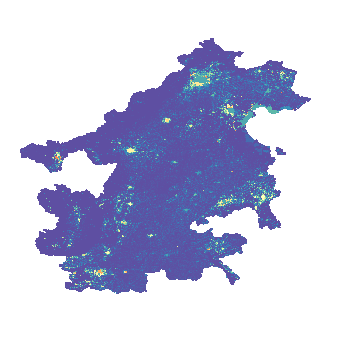

In [222]:
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(8,6))
ax = back_main_clean(fig,extent)
xx,yy = np.meshgrid(lon,lat)
plt.pcolormesh(xx,yy,array,transform=ccrs.PlateCarree(), cmap = plt.cm.Spectral_r )
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax.outline_patch.set_visible(False)

## 12 km KD-tree方法

In [22]:
from scipy.spatial import KDTree
lon_3 = np.linspace(lon.min(),lon.max(),int(len(lon)/12.0))
lat_3 = np.linspace(lat.min(),lat.max(),int(len(lat)/12.0))
sh = (lat_3.shape[0]*lon_3.shape[0],2)
grids = np.zeros(lat_3.shape[0]*lon_3.shape[0]*2).reshape(*sh)
sh_em = (lat_3.shape[0]*lon_3.shape[0])
grids_em = np.zeros(lat_3.shape[0]*lon_3.shape[0]).reshape(sh_em)
print grids_em.shape

(3705,)


In [23]:
x_delta = (lon_3[2] - lon_3[1])
y_delta = (lat_3[2] - lat_3[1])
R = np.sqrt(x_delta**2 + y_delta**2)
k=0
for j in range(0,lat_3.shape[0],1):
    for i in range(0,lon_3.shape[0],1):
        grids[k] = np.array([lon_3[i],lat_3[j]])
        k+=1
T = KDTree(grids)   

In [28]:
start = time.time()
# print em_2016.sum()
xx,yy = np.meshgrid(lon,lat)
lon_,lat_ = xx[0,:],yy[:,0]
for i in range(1,lon_.shape[0],1):
    for j in range(1,lat_.shape[0],1):
        idx = T.query_ball_point([lon_[i],lat_[j]],r=R)     
        if (idx > 1):
            distance = []
            for k in range(0,len(idx),1):
                distance.append(np.sqrt((lon_[i] - grids[k][0])**2\
                                        + (lat_[j] - grids[k][1])**2))
            pos_index = distance.index(min(distance))
            pos = idx[pos_index]
        else:
            pos = idx    
        grids_em[pos] += array[j,i]
print "Process time: " + str(time.time() - start)            
print grids_em.sum()        

Process time: 683.094848871
nan


In [89]:
grids_em_back = grids_em

In [149]:
grids_em = grids_em_back.astype('float')
grids_em[grids_em == 0] = 'nan'
grids_em1 =grids_em.reshape(lat_3.shape[0],lon_3.shape[0])

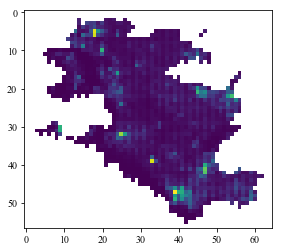

In [150]:
plt.imshow(grids_em1)

In [151]:
grids_em2 = grids_em1
grids_em2[grids_em2 ==0]=np.nan
grids_em2 = grids_em2[::-1]

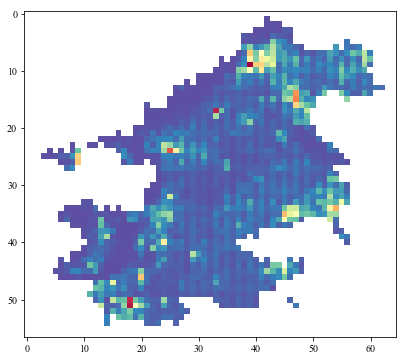

In [155]:
import matplotlib
fig = plt.figure(figsize=(9,6))
plt.imshow(grids_em2,cmap = plt.cm.Spectral_r,)

# 存储

_Export a Numpy Array to a Raster Geotiff in Python_   

When you are done, you can export your NDVI raster data so you could use them in QGIS or ArcGIS or share them with your colleagues.     
To do this you use the rio.write() function. Exporting a raster in python is a bit different from what you may have learned using another language like R.    

In python, you need to:
Create a new raster object with all of the metadata needed to define it. This metadata includes:    
* the shape (rows and columns) of the object
* the coordinate reference system (crs)
* the type of file (you will export a geotiff (.tif) in this lesson
* the type of data being stored (integer, float, etc).

In [175]:
import cartopy.crs as ccrs
import rasterio
pathToRaster = r'././../data/GDPGrid_China2010/2+26_gdp.tif'
raster = gdal.Open(pathToRaster,  gdal.GA_ReadOnly)
width  = raster.RasterXSize
height = raster.RasterYSize
gt     = raster.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

geotransform[0] = top left x    
geotransform[1] = w-e pixel resolution    
geotransform[2] = 0    
geotransform[3] = top left y    
geotransform[4] = 0    
geotransform[5] = n-s pixel resolution (negative value)    

In [186]:
output =  r'././../data/GDPGrid_China2010/2+26_12km-3.tif'
cols, rows =65,57
driver = gdal.GetDriverByName("GTiff")
outDs = driver.Create(output, cols, rows, 1, gdal.GDT_Float32)
outDs.SetGeoTransform((111.51050480406687, 0.12, 0.0, 41.06364329424048, 0.0, -0.12))
#outDs.SetGeoTransform(raster.GetGeoTransform())
outDs.SetProjection(raster.GetProjection())
outDs.GetRasterBand(1).WriteArray(grids_em2)
outDs.GetRasterBand(1).SetNoDataValue(-9999)
del outDs

In [173]:
import cartopy.crs as ccrs
import rasterio
pathToRaster =  r'././../data/GDPGrid_China2010/2+26_12km-2.tif'
raster1 = gdal.Open(pathToRaster,)
array1  = raster1.GetRasterBand(1).ReadAsArray()
gt     = raster1.GetGeoTransform()
array1 = array1.astype('float')
array1[array1 == -9999] = np.nan

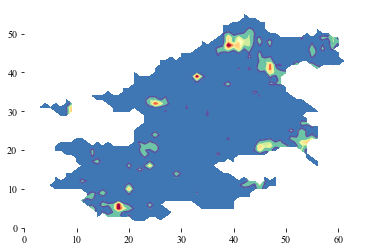

In [208]:
plt.contourf(array1[::-1],cmap = plt.cm.Spectral_r,)
plt.contour(array1[::-1],cmap = plt.cm.Spectral_r,)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax.outline_patch.set_visible(False)

# skimage重采样新方法

In [26]:
import warnings
import rasterio
warnings.filterwarnings('ignore')
import skimage.transform as st 
pathToRaster  = r'././../data/GDPGrid_China2010/2+26_gdp.tif'
raster = gdal.Open(pathToRaster)
array  = raster.GetRasterBand(1).ReadAsArray()
array = array.astype(float)
with rasterio.open(pathToRaster) as src:
    arr = src.read()
    arr[arr ==-9999] = np.nan
    arr  = arr[0,:,:]
    new_shape = (round(arr.shape[0]/3.0),round(arr.shape[1]/3.0))
    newarr= st.resize(arr, new_shape, mode='constant')

In [32]:
print newarr.shape

(231, 263)


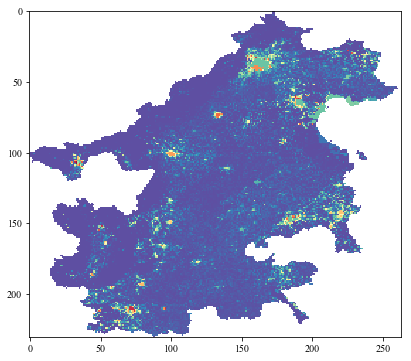

In [31]:
fig = plt.figure(figsize=(8,6))
plt.imshow(newarr, cmap = plt.cm.Spectral_r)

In [207]:
import cartopy.crs as ccrs
import rasterio
pathToRaster = r'././../data/GDPGrid_China2010/2+26_gdp.tif'
raster = gdal.Open(pathToRaster,  gdal.GA_ReadOnly)
width  = raster.RasterXSize
height = raster.RasterYSize
gt     = raster.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

output =  r'././../data/GDPGrid_China2010/2+26_12km-最终.tif'
cols, rows =newarr.shape[1],newarr.shape[0]
driver = gdal.GetDriverByName("GTiff")
outDs = driver.Create(output, cols, rows, 1, gdal.GDT_Float32)
outDs.SetGeoTransform((111.51050480406687, 0.12, 0.0, 41.06364329424048, 0.0, -0.12))
#outDs.SetGeoTransform(raster.GetGeoTransform())
outDs.SetProjection(raster.GetProjection())
outDs.GetRasterBand(1).WriteArray(newarr[::-1])
outDs.GetRasterBand(1).SetNoDataValue(-9999)
del outDs